In [2]:
! ls

drive  sample_data


# Imports

In [31]:
%matplotlib inline
import os
import pandas as pd
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import warnings
import torch
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity
from statistics import mean 


# Globals

In [32]:
#individual tf variables will be as:
slice_tensors = []
num_slices = 4
num_clusters_per_slice = 2
sideLength = 160
sideWidth = 240 
epochs = 100


# Data Loader

In [164]:
class DataLoader():
  def load_data(self, directory, num_images, batch_size):
    fnames = dataloader.load_files(directory)
    sorted_files = sorted(fnames)
    files_to_read = sorted_files[num_images:num_images + batch_size]
    kspace, resc, target = dataloader.get_kspace_esc(files_to_read)

    return kspace, resc, target
    
  def load_dir(self, filePath, num_images):
    files = list(pathlib.Path(filePath).iterdir())
    sorted_files = sorted(files)
    files_to_read = sorted_files[:num_images]
    kspace, resc, target = dataloader.get_kspace_esc(files_to_read)
    return kspace, resc, target

  def load_file(self, filePath, num_images):
    files = pathlib.Path(filePath)
    files_to_read = []
    files_to_read.append(files)
    kspace, resc, target = dataloader.get_kspace_esc(files_to_read)
    return kspace, resc, target

  def load_files(self, directory):
    file_list = []
    folders = list(pathlib.Path(directory).iterdir())
    for folder_name in sorted(folders):
      files = list(pathlib.Path(folder_name).iterdir())
      file_list += files

    return file_list
  
  def get_kspace_esc(self, files):
    kspace = {}
    reconstructed = []
    target = []
    count = 1
    for fname in sorted(files):
      kspace[os.path.basename(fname)] = []
      try:
        with h5py.File(fname, 'r') as data:
          print(fname)
          for i in range(len(data['kspace'])):
            kspace[os.path.basename(fname)].append(data['kspace'][i])
            reconstructed.append(data['reconstruction_esc'][i] if 'reconstruction_esc' in data else None)
            target.append(i)
      except Exception as e:
        print(e)
        print("Unable to open " + str(fname))

    return kspace, reconstructed, target

  def show_slices(self, kspace, target):
    warnings.warn('Please do not try to visualize too many slices ( < 100)')
    for key in sorted(kspace):
        space = kspace[key]
        kspace_abs = [np.log(np.abs(k) + 1e-9) for k in space]
        for i, x in enumerate(zip(kspace_abs, target)):
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
            axes[0].imshow(x[0])
            axes[1].imshow(x[1], cmap='gray')
            axes[0].set_title("k-space slice " + str(i))
            axes[1].set_title("image slice " + str(i))
            fig.tight_layout()
            
  def show_recons_d(self, original, recon):
        with h5py.File(original, 'r') as data:
            h5_data = data['reconstruction_esc'][()]
            og = self.reformat_slices(h5_data)
        with h5py.File(recon, 'r') as data_recon:
            h5_recon_data = data_recon['reconstruction'][()]
            reconstructed = self.reformat_slices(h5_recon_data)

        print(self.ssim(h5_data, h5_recon_data))
        for i, x in enumerate(zip(og, reconstructed)):
            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
            axes.imshow(x[0], cmap='gray')
            #axes.imshow(x[1], cmap='gray')
            #axes.set_title("gnd truth slice " + str(i))
            #axes.set_title("reconstructed slice " + str(i))
            fig.tight_layout()
        
  def load_batch(self, directory):
        fnames = dataloader.load_files(directory)
        sorted_files = sorted(fnames)
        return sorted_files

  def reformat_slices(self, data):
    reconstructed = []
    for i in range(len(data)):
        reconstructed.append(data[i])
        
    return reconstructed
    
  def show_recons(self, original, recon):
    with h5py.File(original, 'r') as data:
        h5_data = data['reconstruction_esc'][()]
        og = self.reformat_slices(h5_data)
    with h5py.File(recon, 'r') as data_recon:
        h5_recon_data = data_recon['reconstruction'][()]
        reconstructed = self.reformat_slices(h5_recon_data)

    print(self.ssim(h5_data, h5_recon_data))
    for i, x in enumerate(zip(og, reconstructed)):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
        axes[0].imshow(x[0], cmap='gray')
        axes[1].imshow(x[1], cmap='gray')
        axes[0].set_title("gnd truth slice " + str(i))
        axes[1].set_title("reconstructed slice " + str(i))
        fig.tight_layout()

  def get_dimensions(self, kspace):
    kspace_abs = np.log(np.abs(kspace) + 1e-9)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    axes.imshow(kspace_abs)
    print("Shape of masked kspace: " + str(kspace.shape))
    
  def ssim(self, og, recons):
      return structural_similarity(
      og.transpose(1, 2, 0), recons.transpose(1, 2, 0), multichannel=True, data_range=og.max()
      )  
    
  def group_ssim(self, og_dir, recon_dir):
    recon_files = sorted(list(pathlib.Path(recon_dir).iterdir()))
    og_test_files = sorted(list(pathlib.Path(og_dir).iterdir()))
    og_test_files.pop(0)
    #recon_files.pop(0)
    ssims = []
    for x in zip(og_test_files, recon_files):
        with h5py.File(x[0], 'r') as data:
            h5_data = data['reconstruction_esc'][()]
        with h5py.File(x[1], 'r') as data_recon:
            h5_recon_data = data_recon['reconstruction'][()]
        ssim = self.ssim(h5_data, h5_recon_data)
        ssims.append(ssim)
        print('SSIM for ' + str(os.path.basename(x[0])) + ' & ' + str(os.path.basename(x[1])) + ': ' + str(ssim))

    return mean(ssims)

# @375

In [165]:
# peep https://papers.nips.cc/paper/8451-cascaded-dilated-dense-network-with-two-step-data-consistency-for-mri-reconstruction
# both the main paper + the supplemental

Initial Gaussian Model to select clusters in the periphery and centre of k-space data. 

In [166]:
dataloader = DataLoader()
! ls fastMRI/experiments/unet/reconstructions/

file1000170.h5	file1000181.h5	file1000199.h5	file1000475.h5	file1000489.h5
file1000172.h5	file1000185.h5	file1000261.h5	file1000479.h5	file1000490.h5
file1000173.h5	file1000188.h5	file1000262.h5	file1000481.h5	file1000492.h5
file1000176.h5	file1000191.h5	file1000265.h5	file1000482.h5	file1000493.h5
file1000177.h5	file1000193.h5	file1000271.h5	file1000483.h5	file1000495.h5
file1000179.h5	file1000195.h5	file1000275.h5	file1000485.h5	file1000499.h5
file1000180.h5	file1000198.h5	file1000472.h5	file1000486.h5


In [167]:
reconfilePath = 'fastMRI/experiments/unet/reconstructions/'
ogfilePath = 'singlecoil_test/'

0.7520563725906021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


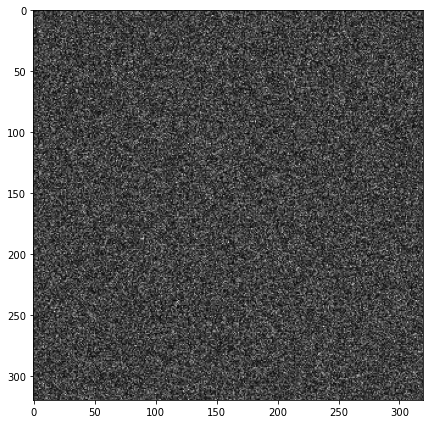

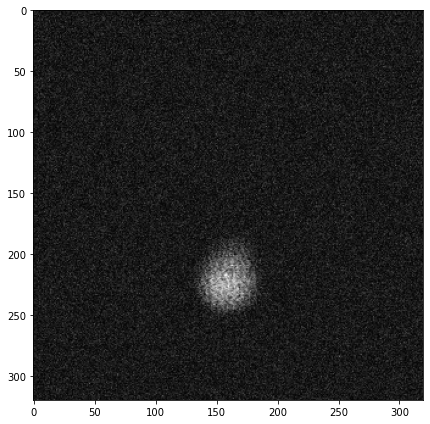

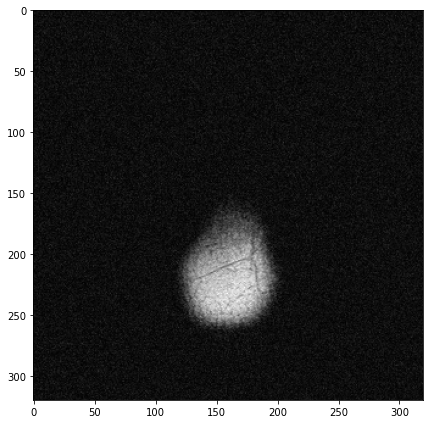

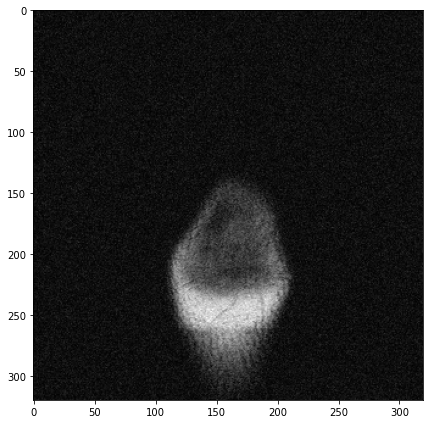

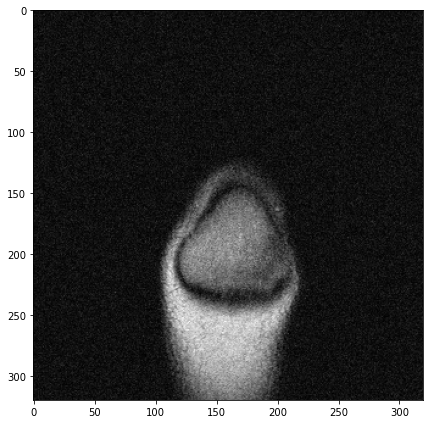

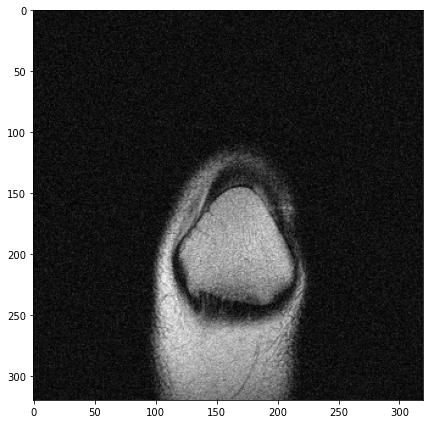

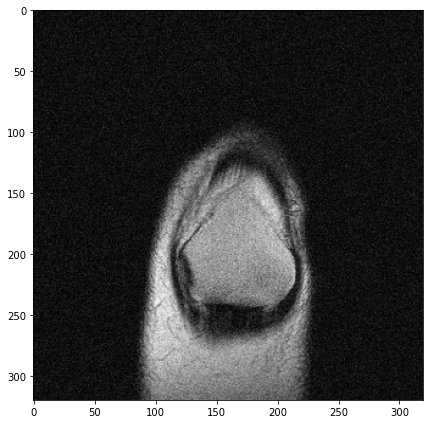

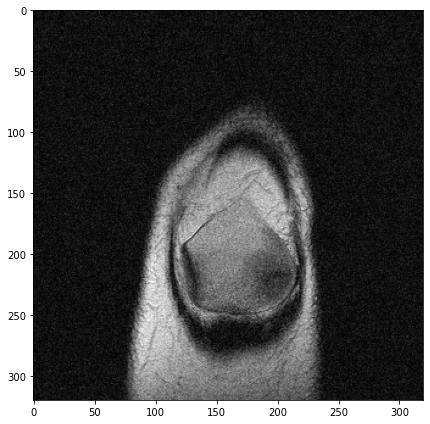

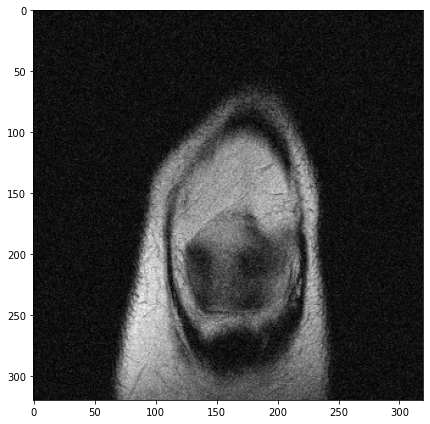

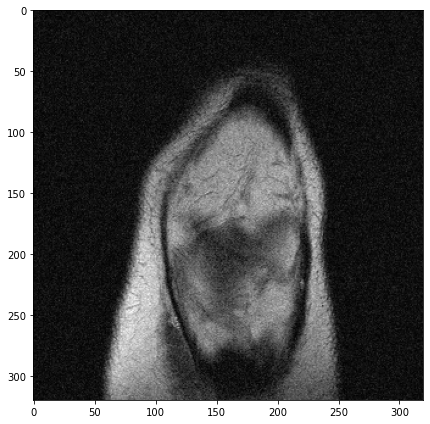

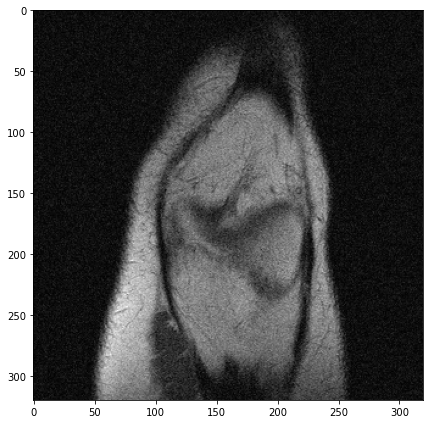

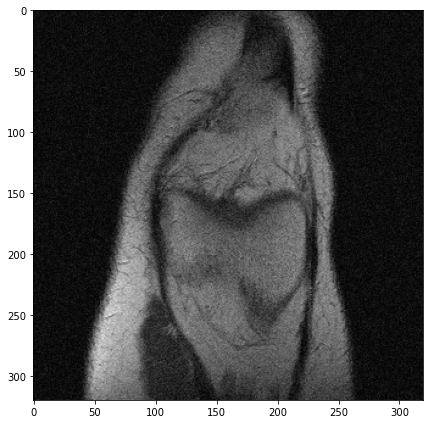

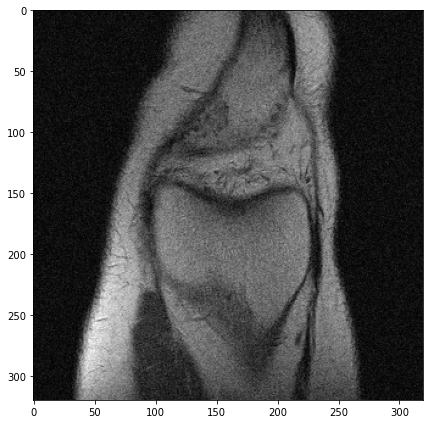

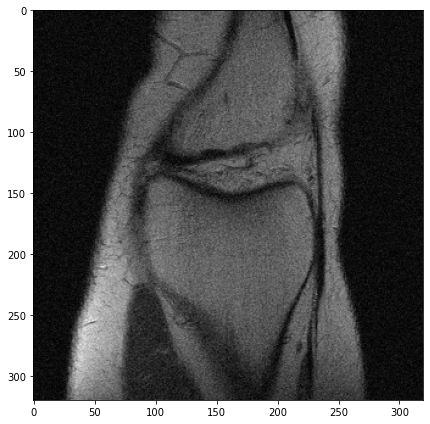

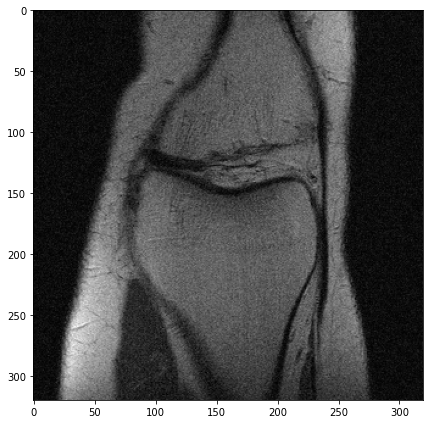

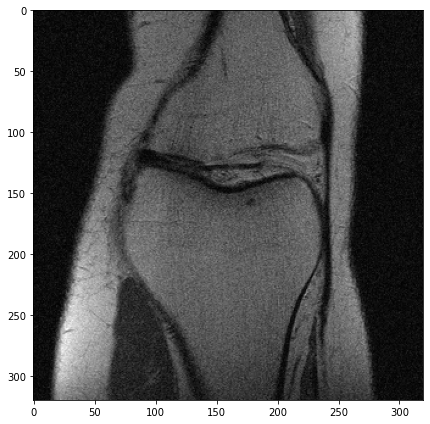

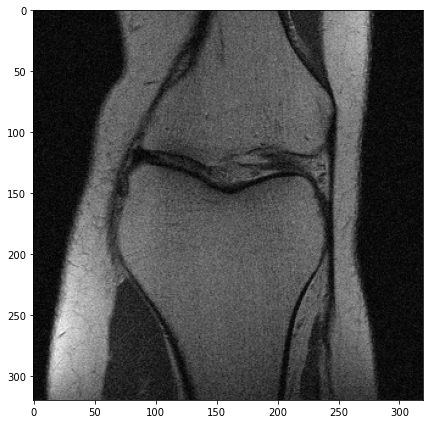

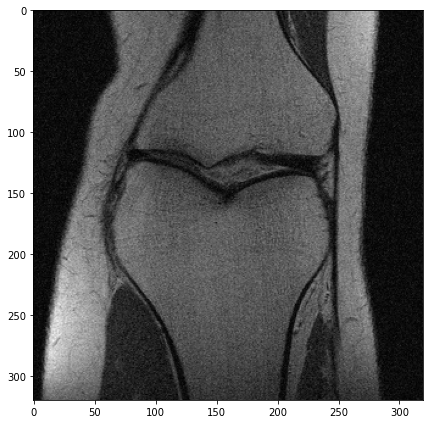

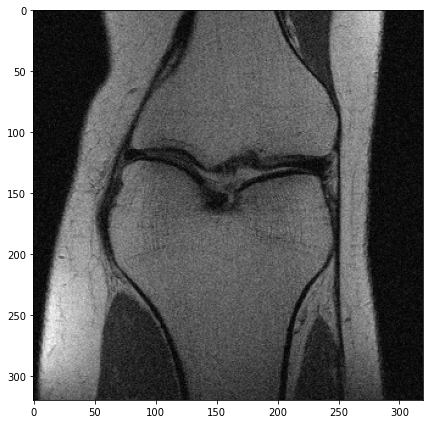

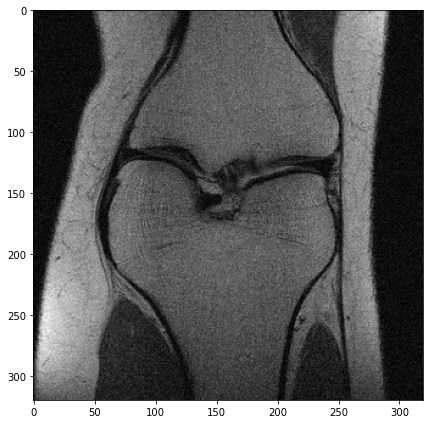

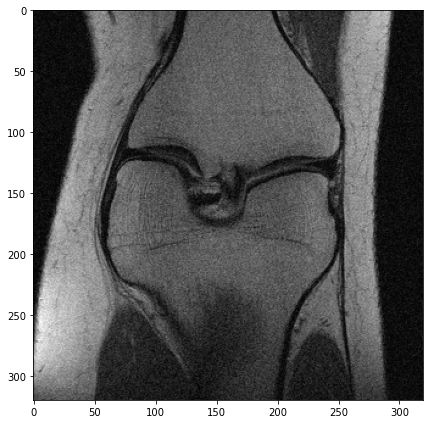

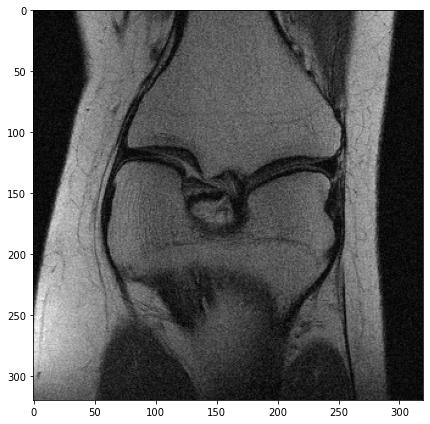

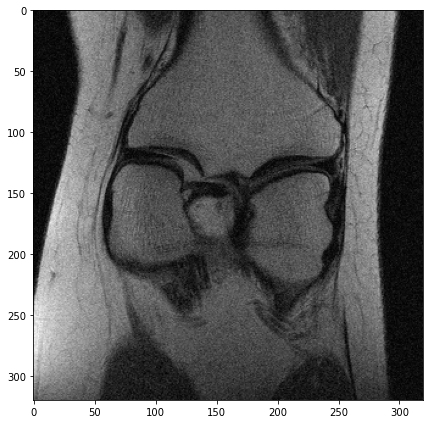

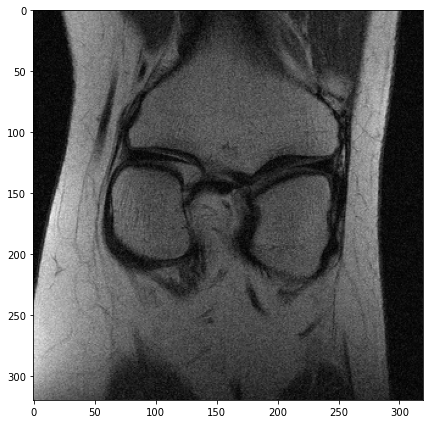

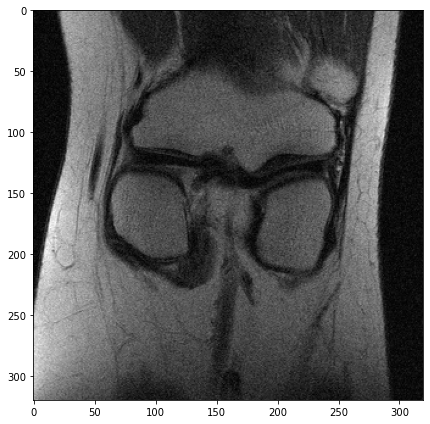

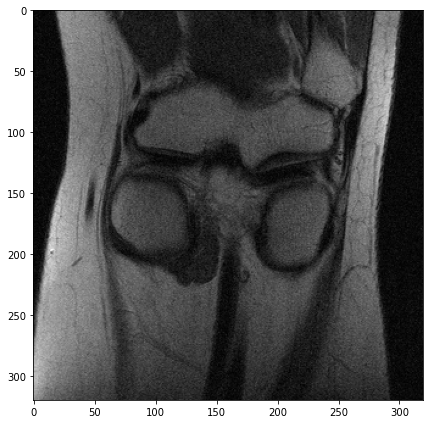

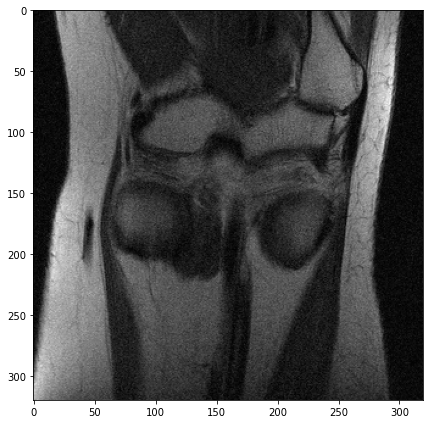

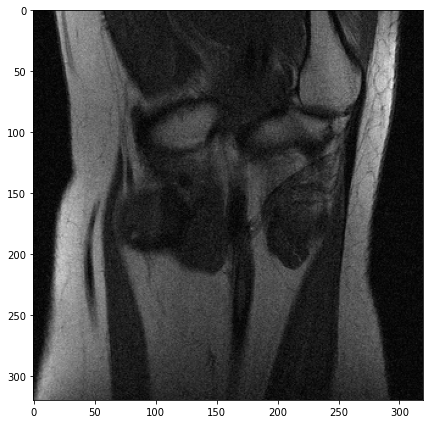

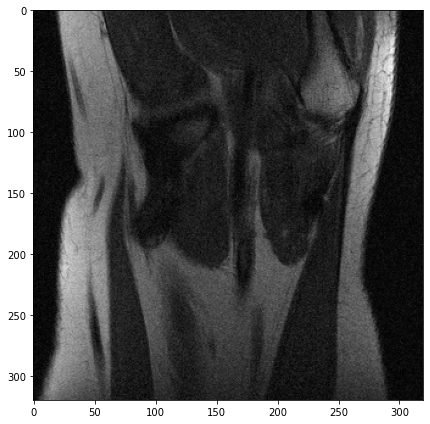

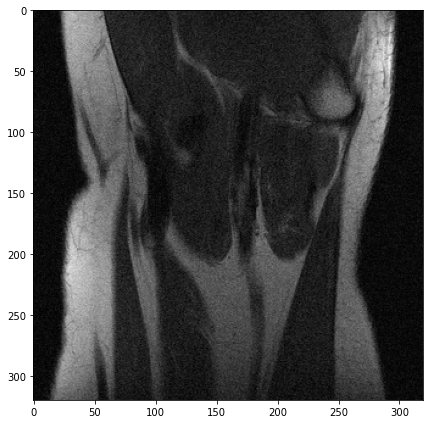

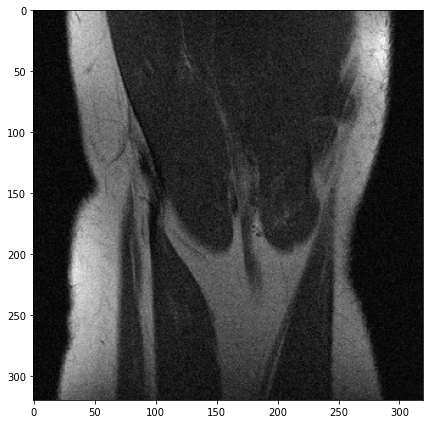

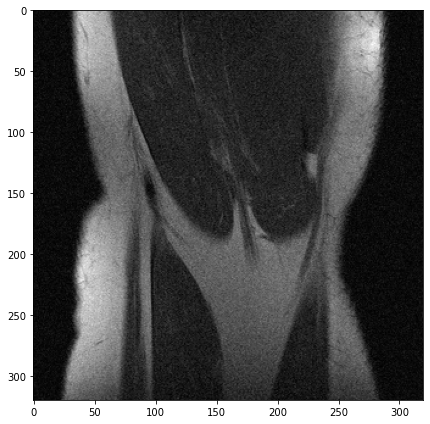

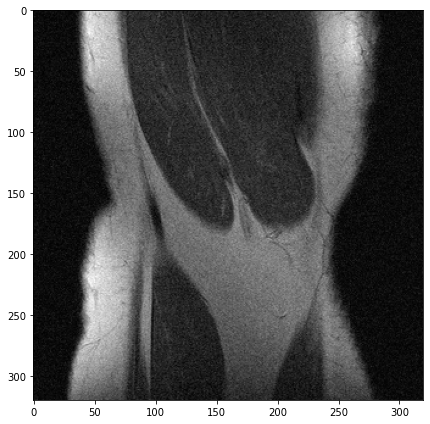

In [168]:
with h5py.File(ogfilePath + 'file1000195.h5', 'r') as data:
    h5_data = data['reconstruction_esc'][()]
    og = dataloader.reformat_slices(h5_data)
with h5py.File( reconfilePath + 'file1000195.h5', 'r') as data_recon:
    h5_recon_data = data_recon['reconstruction'][()]
    reconstructed = dataloader.reformat_slices(h5_recon_data)
    
og[14]
reconstructed[14]

dataloader.show_recons_d(ogfilePath + 'file1000195.h5', reconfilePath + 'file1000195.h5')

In [163]:
print("Avg SSIM of test group: " + str(dataloader.group_ssim(ogfilePath, reconfilePath)))

SSIM for file1000170.h5 & file1000170.h5: 0.8351368690101384
SSIM for file1000172.h5 & file1000172.h5: 0.8060968236073088
SSIM for file1000173.h5 & file1000173.h5: 0.8239336191687056
SSIM for file1000176.h5 & file1000176.h5: 0.7842602315503281
SSIM for file1000177.h5 & file1000177.h5: 0.7306905737080154
SSIM for file1000179.h5 & file1000179.h5: 0.8362493954722068
SSIM for file1000180.h5 & file1000180.h5: 0.8688798171285789
SSIM for file1000181.h5 & file1000181.h5: 0.7743558483005468
SSIM for file1000185.h5 & file1000185.h5: 0.7295426968041536
SSIM for file1000188.h5 & file1000188.h5: 0.7795307770470898
SSIM for file1000191.h5 & file1000191.h5: 0.8024441477190389
SSIM for file1000193.h5 & file1000193.h5: 0.8096045263585576
SSIM for file1000195.h5 & file1000195.h5: 0.7520563725906021
SSIM for file1000198.h5 & file1000198.h5: 0.8172020961232741
SSIM for file1000199.h5 & file1000199.h5: 0.8591159679238668
SSIM for file1000261.h5 & file1000261.h5: 0.8550964206952056
SSIM for file1000262.h5 

In [101]:
dataloader.show_recons(ogfilePath + 'file1000195.h5', reconfilePath + 'file1000195.h5')

0.7520563725906021


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Error in callback <function flush_figures at 0x7f0f8b3c95f0> (for post_execute):


KeyboardInterrupt: 

singlecoil_test/file1000195.h5
Shape of masked kspace: (640, 372)


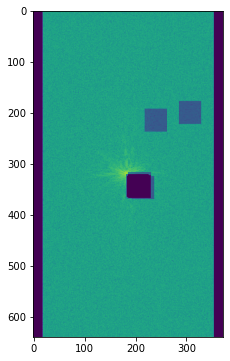

In [67]:
kspace, resc, target = dataloader.load_file('file1000195.h5', 2)
dataloader.get_dimensions(kspace['file1000195.h5'][14])

In [4]:
files = dataloader.load_batch('/content/drive/My Drive/singlecoil_train_raw')
files

NameError: name 'pathlib' is not defined

In [ ]:
kspace, resc, target = dataloader.load_data('/content/drive/My Drive/singlecoil_train_raw', 800)
#dataloader.show_slices(kspace, resc)

/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000012.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000021.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000023.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000027.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000029.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000032.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000039.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000040.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000043.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000045.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000048.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000053.h5
/content/drive/My Drive/singlecoil_train_raw/singlecoil_1/file1000057.h5
/content/drive/My Drive/singlecoil_train_raw/single

# Helpers

[[ 2.46817111e-05-9.30176006e-06j  2.48193702e-05-9.38867898e-06j
   2.44554185e-05-8.45804797e-06j ...  2.51244215e-05-1.03956866e-05j
   2.46839636e-05-9.95675892e-06j  2.47034691e-05-9.63061582e-06j]
 [-8.93041268e-07-4.14900689e-08j -1.42516977e-06+9.96019584e-07j
  -8.93766837e-07+1.27210666e-06j ... -1.35055985e-06+3.85320308e-07j
  -1.78842180e-06+7.65625329e-07j -1.29022897e-06-3.18059180e-07j]
 [-5.49262661e-07-4.95581918e-08j -1.86439377e-07+1.83518296e-07j
  -8.28067624e-07+1.68054243e-07j ... -5.54589244e-07-7.14659179e-07j
  -4.47701500e-08-5.96928783e-07j -6.10532060e-07+1.96123526e-07j]
 ...
 [-5.99521710e-06+3.86944843e-07j -7.07429908e-06+8.42807107e-07j
  -7.29105529e-06+9.95032605e-07j ... -3.64188005e-06-1.32654467e-06j
  -4.25950208e-06-9.82570705e-07j -5.12802359e-06-6.53568023e-07j]
 [ 3.74220159e-06+2.12617696e-06j  2.86948925e-06+1.96252080e-06j
   2.46321573e-06+5.66491780e-07j ...  5.19780636e-06+5.00362671e-06j
   4.34191395e-06+4.51936143e-06j  4.02393836e-

TypeError: Image data of dtype complex128 cannot be converted to float

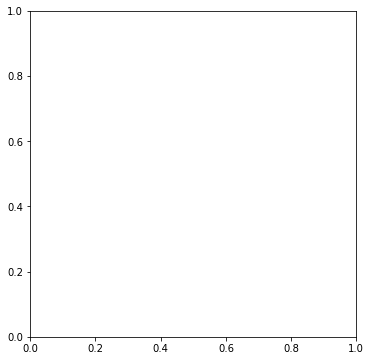

In [49]:
import numpy

x = numpy.fft.ifft(np.fft.ifftshift(kspace['file1000195.h5'][14]))
print(x)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
axes.imshow(x, cmap='gray')
fig.tight_layout()

In [ ]:
def show_slices(kspace, centers):
  warnings.warn('Please do not try to visualize too many slices ( < 100)')
  kspace_abs = [np.log(np.abs(kspace) + 1e-22)]
#   plt.figure(figsize=(8,6))
#   print(kspace_abs[0][0])
#   plt.scatter(kspace_abs[0][0][0], kspace_abs[0][][1])
  plt.show()
  plt.figure(figsize=(8,6))
#   centers = np.abs([np.log(np.abs(centers) + 1e-9)])
#   print("centers", centers)
  xval = [x[0] for x in centers]
  yval = [x[1] for x in centers]
  for i, x in enumerate(zip(kspace_abs, centers)):
      #fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
      #axes[0].imshow(x[0])
      #axes[0].scatter(x[1][0], x[1][1], color='red')
      plt.imshow(x[0])
      plt.scatter(xval, yval, color='red')
      #axes[0].imshow(centers_abs, cmap='gray')
      #axes[0].set_title("k-space slice " + str(i))
      #axes[1].set_title("image slice " + str(i))
      #fig.tight_layout()

            

# Implementation

In [ ]:
mute_visualization = True

In [342]:
# data formatting
def getNkSpaceSlices(kspace, n = -1):
  clusterResIm = []

  sliceCount = n
  if n == -1: 
    sliceCount = len(kspace)

  for i in range(sliceCount):
    kspace_real = np.real(kspace[i])
    kspace_imag = np.imag(kspace[i])

    theta = np.angle(kspace[i])
    mag = np.abs(kspace[i])
    x = mag * np.cos(theta)
    y = mag * np.sin(theta)

    flat_real = x.flatten()
    flat_imag = y.flatten()
    data = list(zip(flat_real, flat_imag))

    #Superimpose clusters on k-space data
    #i.e. (matrixWidth - sideWidth) * (matrixLength - sideLength) / (matrixWidth*matrixLength) *100
    K = 10

    kspace_abs = np.array(np.log(np.abs(kspace[i]) + 1e-9))
    kspace_reshaped = np.reshape(kspace_abs, [-1, 1])
    # kmeans_test = KMeans(n_clusters = K, max_iter = epochs, n_init = 16).fit(kspace_reshaped)

    kmeans_real = KMeans(n_clusters = K, max_iter = epochs, n_init = 16).fit(data)
    clusterCenters = kmeans_real.cluster_centers_
    # clusterCentersTest = kmeans_test.cluster_centers_

    if not mute_visualization:
      print("Cluster centers", clusterCenters)
    #print("Magnitude cluster centers", clusterCentersTest)

    # Code for visualizing the data
    xvals = []
    yvals = []
    for pt in clusterCenters:
      xvals.append(pt[0])
      yvals.append(pt[1])

    if not mute_visualization:
      plt.figure(figsize=(8,6))
      plt.xlim(-8e-5, 8e-5)
      plt.ylim(-8e-5, 8e-5)
      plt.scatter(flat_real, flat_imag,c = kmeans_real.labels_, cmap="Set2", alpha = 0.3)
      plt.scatter(xvals, yvals, marker="X", cmap="Reds")
      plt.show()
    clusterResIm.append(clusterCenters)

  print("Set of clusters:")
  print(clusterResIm)
  return clusterResIm

# Match Clusters & Zero-Fill

In [343]:
def matchAndZeroFill(kSpace, clusters, squareSize):
  closestPoints = closestPointsToClusters(kSpace, clusters)
  for centre in closestPoints:
    zeroMask(kSpace, centre, squareSize)
  return closestPoints, kSpace
  
def closestPointsToClusters(kSpace, clusters):
  # array of indices into the kSpace array, parallel-indexed w/ clusters
  if not mute_visualization:
    print("Actual Cluster Centres")
    print(clusters)

  closestPoints = []
  pointIndex = 0

  for clusterX, clusterY in clusters:
    minDist = 666666.6
    bestFit = (-1,-1)
    for i in range(kSpace.shape[0]):
      for j in range(kSpace.shape[1]):
        x = np.real(kSpace[i][j])
        y = np.imag(kSpace[i][j])
        # Euclidean distance calculation b/w the cluster centre, and the kSpace pt.
        dist = np.sqrt(abs(clusterX - x)**2 + abs(clusterY - y)**2)
        #dist = np.linalg.norm(clusterX - x) + np.linalg.norm(clusterY - y)
        if dist < minDist:
          minDist = dist
          bestFit = (i,j)
    closestPoints.append(bestFit)
  
  if not mute_visualization:
    print("Index of cluster centres")
    print(closestPoints)

    print("Approximation of cluster centres")
    for m in range(len(closestPoints)):
      print(kSpace[closestPoints[m][0]][closestPoints[m][1]])

  return closestPoints

def zeroMask(kSpace, centre_loc, sq_len):
  kSpace[centre_loc]
  for i in range(sq_len):
    for j in range(sq_len):
      	if ((centre_loc[0] + i) < kSpace.shape[0] and (centre_loc[1] + j) < kSpace.shape[1] and j % 2):
    		  kSpace[centre_loc[0] + i][centre_loc[1] + j] = 0.0

# Main

In [344]:
%cd /content/drive/My\ Drive/singlecoil_backup

[Errno 2] No such file or directory: '/content/drive/My Drive/singlecoil_backup'
/home/jupyter


In [345]:
import torch

In [346]:
subSampledKSpace = {}
file_count = len(dataloader.load_batch('/content/drive/My Drive/singlecoil_train_raw'))

limitFileCount = False # limit the number of files to subsample from
maxFilesToSubSample = 1 # only need to set/worry about this if the above bool is true
slicesPerFile = -1 # set this to -1 to take all slices from the files
batch_start = 0
batch_size = 5
count = 0;
# Due to RAM req
while batch_start < file_count:
  print("Running for batch: " + str(batch_start) + " to " + str(batch_start + batch_size))
  kspace, resc, target = dataloader.load_data('/content/drive/My Drive/singlecoil_train_raw', batch_start, batch_size)
  for sample in sorted(kspace):
      print("Working for file: " + sample)
      if limitFileCount and (maxFilesToSubSample == 0):
          break

      kSpace = kspace[sample]
      if not sample in subSampledKSpace.keys():
          subSampledKSpace[sample] = []

      #kMeans on the first 'slicesPerFile' # of slices
      centreSlices = getNkSpaceSlices(kSpace, slicesPerFile)

      # Obtain subsamples for 'slicesPerFile' # of slices
      subSampled = subSample(kSpace, centreSlices, slicesPerFile)

      subSampledKSpace[sample].extend(subSampled)

      if limitFileCount:
          maxFilesToSubSample -= 1
  writeToFilesv2Final(subSampledKSpace)
  torch.cuda.empty_cache()
  batch_start += batch_size

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/singlecoil_train_raw'

In [ ]:
writeToFilesv2Final(subSampledKSpace)

In [ ]:
def subSample(kSpace, clusterCentreNSlices, n = -1):
    #Run this to mask the first n slices we found centroids for. 
    sliceCount = n
    if n == -1:
        sliceCount = len(clusterCentreNSlices)
    
    subSampledKSpaces = []
    for i in range(sliceCount):
        print("*************Data for slice {id}***********************".format(id=i))
        kSpaceSliceCopy = kSpace[i].copy()
        centres_loc, kSpaceZ = matchAndZeroFill(kSpaceSliceCopy, clusterCentreNSlices[i], 45) #45 is length of square

        rawCenters = []
        convertedCenters = []

        if not mute_visualization:
          print("*************Displaying slice {id}***********************".format(id=i))
          plt.figure(figsize=(8,6))
          kspace_abs = [np.log(np.abs(kSpace[i]) + 1e-22)]
          for i, x in enumerate(kspace_abs):
              plt.imshow(x)

          for loc in centres_loc:
              plt.scatter(loc[1], loc[0], color='red')

          plt.figure(figsize=(8,6))
          kspace_abs1 = [np.log(np.abs(kSpaceZ) + 1e-9)]
          for i, x in enumerate(kspace_abs1):
              plt.imshow(x)

          plt.figure(figsize=(8,6))
          for i, x in enumerate(kspace_abs1):
              plt.imshow(x)

          for loc in centres_loc:
              plt.scatter(loc[1], loc[0], color='red')
          plt.show()

        subSampledKSpaces.append(kSpaceZ)
    
    # return the subsampled kSpace
    return subSampledKSpaces

def remove_current_kspace(filename):
    with h5py.File(filename,  "a") as f:
        print(list(f.keys()))
        del f['kspace']
        print(list(f.keys()))
    f.close()

def print_keys(filename):
      with h5py.File(filename,  "a") as f:
        print(list(f.keys()))
        f.close()

def writeToFiles(kSpace):
    # iterates through all files in the kSpace dictionary, and writes each file's slices into a
    # single .h5 file. 
    print("*************Writing data to hdf5 files...***********************")
    for fileName in sorted(kSpace):
        print("Writing slices for " + fileName + ":")
        samples = kSpace[fileName]
        try:
          remove_current_kspace(fileName)
        except:
          print("Move on")
        for i, sample in enumerate(samples):
            print("Writing slice " + str(i) + "...")
            dataFrame = pd.DataFrame(sample)
            dataFrame.to_hdf(fileName, key="kspace", mode='r+')
        print_keys(fileName)
        
# USE THIS WRITE FUNCTION, NOT THE ONE ABOVE.
def writeToFilesv2Final(kSpace):
    print("*************Writing data to hdf5 files...***********************")
    for fileName in sorted(kSpace):
        print("Writing slices for " + fileName + ":")
        samples = kSpace[fileName]
        try:
          remove_current_kspace(fileName)
        except:
          print("Move on")
        with h5py.File(fileName,  "a") as dataStore:
            # Toss all the slices into the file in one go
            dataStore.create_dataset("kspace", data = samples) 
            dataStore.close()
        print_keys(fileName)

# Verifies the format of the entered dataset. The printout should look something like this:
# <HDF5 dataset "kspace": shape (32, 640, 372), type "<c8">
def sanityCheck(fileName):
    with h5py.File(fileName,  "a") as dataStore:
        print(dataStore['kspace'])
        dataStore.close()

In [ ]:
sanityCheck("file1000012.h5")
#len(subSampledKSpace["file1000129.h5"])

NameError: ignored

In [ ]:
!ls

file1000001.h5	file1000499.h5	file1001071.h5	file1001609.h5	file1002094.h5
file1000002.h5	file1000501.h5	file1001079.h5	file1001613.h5	file1002095.h5
file1000003.h5	file1000504.h5	file1001082.h5	file1001615.h5	file1002096.h5
file1000005.h5	file1000508.h5	file1001084.h5	file1001616.h5	file1002097.h5
file1000010.h5	file1000509.h5	file1001087.h5	file1001617.h5	file1002098.h5
file1000012.h5	file1000510.h5	file1001092.h5	file1001619.h5	file1002099.h5
file1000015.h5	file1000511.h5	file1001094.h5	file1001622.h5	file1002103.h5
file1000021.h5	file1000514.h5	file1001098.h5	file1001623.h5	file1002107.h5
file1000023.h5	file1000517.h5	file1001099.h5	file1001627.h5	file1002111.h5
file1000027.h5	file1000518.h5	file1001101.h5	file1001628.h5	file1002112.h5
file1000029.h5	file1000521.h5	file1001102.h5	file1001629.h5	file1002113.h5
file1000032.h5	file1000529.h5	file1001106.h5	file1001630.h5	file1002115.h5
file1000039.h5	file1000535.h5	file1001108.h5	file1001632.h5	file1002117.h5
file1000040.h5	file100053